In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import seaborn as sns

## Load Data and Preprocess

In [2]:
import os
import shutil
import random
from tqdm import tqdm

data_dir = "./class"       
output_dir = "./output_data"  
val_split = 0.2             

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Run the split only if it hasn't already been done
if not os.path.exists(train_dir):
    print("🔄 Splitting dataset...")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Loop through each class folder
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path): 
            continue

        # Create corresponding train/ and val/ class folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        images = os.listdir(class_path)
        random.shuffle(images)

        # Split index
        split_idx = int(len(images) * (1 - val_split))
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copy training images
        for img in tqdm(train_images, desc=f"Training - {class_name}"):
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(train_dir, class_name, img)
            )

        # Copy validation images
        for img in tqdm(val_images, desc=f"Validation - {class_name}"):
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(val_dir, class_name, img)
            )

    print("Dataset split completed!")
else:
    print("Dataset already split — skipping this step.")


Dataset already split — skipping this step.


## Load Training Data

In [3]:
train_set = image_dataset_from_directory(
    './output_data/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    verbose=True,
)

Found 3343 files belonging to 4 classes.


## Load Validation Data

In [4]:
validation_set = image_dataset_from_directory(
    './output_data/val',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    verbose=True,
)

Found 838 files belonging to 4 classes.


In [8]:
train_set 
validation_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [10]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert one-hot labels to class index
        if y_true.shape[-1] > 1:
            y_true = tf.argmax(y_true, axis=-1)

        # Convert probabilities to predicted class
        y_pred = tf.argmax(y_pred, axis=-1)

        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + 1e-7))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [10]:
# If your dataset is a tf.data.Dataset yielding (images, labels):
from collections import Counter
import numpy as np

def get_label_counts(ds, max_batches=200):
    counts = Counter()
    total = 0
    for i, (x,y) in enumerate(ds):
        if isinstance(y, tf.Tensor):
            # if one-hot -> convert to class index
            if y.ndim > 1 and y.shape[-1] > 1:
                labels = np.argmax(y.numpy(), axis=-1)
            else:
                labels = y.numpy()
        else:
            labels = np.array(y)
        counts.update(labels.flatten().tolist())
        total += labels.shape[0]
        if i >= max_batches-1:
            break
    return counts, total

train_counts, train_total = get_label_counts(train_set)
val_counts, val_total = get_label_counts(validation_set)

print("Train counts:", train_counts, " total:", train_total)
print("Val counts:  ", val_counts, " total:", val_total)


Train counts: Counter({1: 855, 3: 853, 0: 830, 2: 805})  total: 3343
Val counts:   Counter({3: 214, 1: 214, 0: 208, 2: 202})  total: 838


## MobileNetV3 Model

In [33]:
Input_shape = (224, 224, 3)

# Create MobileNetV3 base model without the top classification layer
base_model = keras.applications.MobileNetV3Large(    
    input_shape=Input_shape,
    alpha=1.0,
    minimalistic=False,
    include_top=False,  # Remove the top layer for transfer learning
    weights="imagenet",
    pooling='avg',  # Add global average pooling
    include_preprocessing=False,  # We'll handle preprocessing separately
)

# Make the base model trainable (optional - you can freeze it for faster training)
base_model.trainable = True

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


In [34]:
# Build the complete model using Functional API for better control
inputs = tf.keras.Input(shape=Input_shape)

# Preprocessing layer
x = tf.keras.layers.Rescaling(1./255.0)(inputs)  # Normalize pixel values to [0,1]

# Base model
x = base_model(x, training=False)  # Keep BatchNorm in inference mode

# Classification head
outputs = tf.keras.layers.Dense(4, activation='softmax', name='predictions')(x)

# Create the model
model_sequential = tf.keras.Model(inputs, outputs)

In [ ]:
# This cell is no longer needed - model is built above
# model_sequential.add(tf.keras.layers.InputLayer(input_shape=Input_shape))

C:\Users\jayen\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
# This cell is no longer needed - model is built above
# model_sequential.add(mobileNet_model)

In [17]:
# This cell is no longer needed - Dense layer is added above
# model_sequential.add(tf.keras.layers.Dense(units = 4, activation='softmax'))

In [35]:
Metrics = [
    'accuracy',
    tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
    F1Score(name='f1')
]

model_sequential.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=Metrics
)   

In [36]:
model_sequential.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 2,975,796 (11.35 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [20]:
for x, y in train_set.take(1):
    print("y shape:", y.shape)
    print("y example:", y[0])
    break


y shape: (32, 4)
y example: tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


In [ ]:
# Reload the datasets to avoid preprocessing conflicts
train_set = image_dataset_from_directory(
    './output_data/train',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=False,
)

validation_set = image_dataset_from_directory(
    './output_data/val',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=False,
)

In [31]:
# Debug: Check the actual shape of the data
for x, y in train_set.take(1):
    print("Input shape:", x.shape)
    print("Output shape:", y.shape)
    print("Input min/max:", tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy())
    break

Input shape: (32, 224, 224, 3)
Output shape: (32, 4)
Input min/max: 0.0 255.0


In [37]:
print(type(train_set))
print(type(validation_set))



training_history = model_sequential.fit(
    train_set, 
    validation_data=validation_set, 
    epochs=15,
    verbose=1
)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Epoch 1/15


105/105 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6776 - cat_accuracy: 0.6776 - f1: 0.9014 - loss: 0.8292 - val_accuracy: 0.5465 - val_cat_accuracy: 0.5465 - val_f1: 0.9088 - val_loss: 1.4671
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6776 - cat_accuracy: 0.6776 - f1: 0.9014 - loss: 0.8292 - val_accuracy: 0.5465 - val_cat_accuracy: 0.5465 - val_f1: 0.9088 - val_loss: 1.4671
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9289 - cat_accuracy: 0.9289 - f1: 0.9779 - loss: 0.2142 - val_accuracy: 0.5477 - val_cat_accuracy: 0.5477 - val_f1: 0.9226 - val_loss: 1.5149
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9289 - cat_accuracy: 0.9289 - f1: 0.9779 - loss: 0.2142 - val_accuracy: 0.5477 - val_cat_accuracy: 0.5477 - val_f1: 0.9226 - val_loss: 1.5149
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9649 - cat_accuracy: 0.9649 - f1: 0.9905 - loss: 0.1179 - val_accuracy: 0.5095 - val_cat_accuracy: 0.5095 - 

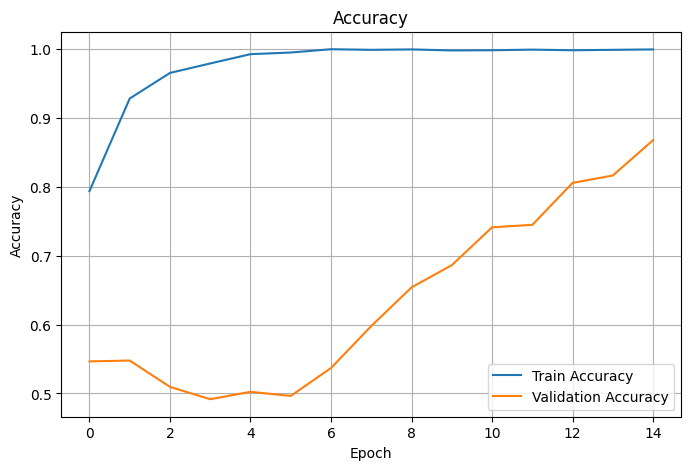

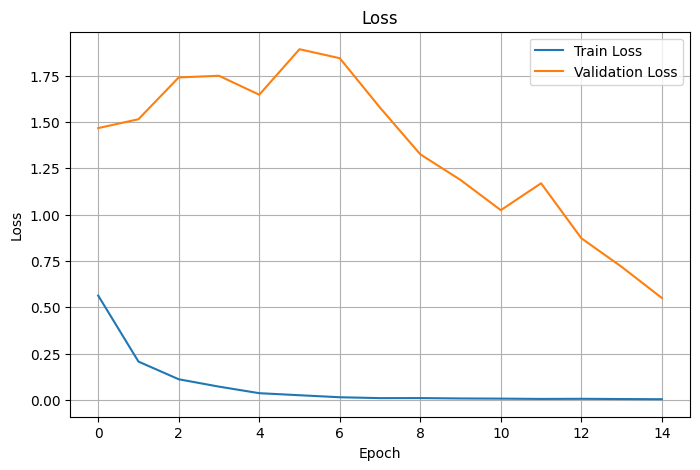

In [38]:
import matplotlib.pyplot as plt

history = training_history.history

# --- Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss ---
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Data Augmentation

In [39]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet_v2 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.map(lambda x, y: (preprocess_input(x), y))
validation_set = validation_set.map(lambda x, y: (preprocess_input(x), y))

train_set = train_set.prefetch(AUTOTUNE)
validation_set = validation_set.prefetch(AUTOTUNE)



## ResNet50 v2 Model

In [40]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,             
    weights="imagenet",            
    input_shape=(224, 224, 3),     
    pooling='avg'                  
)

# --- Minimal improvement: fine-tune last 40 layers ---
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

x = base_model.output

# --- Minimal improvement: stronger head ---
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 144s 2us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 144s 2us/step


In [41]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    F1Score(name='f1')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # better LR
    loss='categorical_crossentropy',
    metrics=metrics
)


In [42]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-7
    )
]


In [43]:
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.4357 - f1: 0.8730 - loss: 1.2420 - precision: 0.5498 - recall: 0.1847 - val_accuracy: 0.7017 - val_f1: 0.9348 - val_loss: 0.7680 - val_precision: 0.7673 - val_recall: 0.5704 - learning_rate: 1.0000e-05
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.4357 - f1: 0.8730 - loss: 1.2420 - precision: 0.5498 - recall: 0.1847 - val_accuracy: 0.7017 - val_f1: 0.9348 - val_loss: 0.7680 - val_precision: 0.7673 - val_recall: 0.5704 - learning_rate: 1.0000e-05
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.8162 - f1: 0.9509 - loss: 0.5605 - precision: 0.8923 - recall: 0.7107 - val_accuracy: 0.8389 - val_f1: 0.9562 - val_loss: 0.4525 - val_precision: 0.8652 - val_recall: 0.7888 - learning_rate: 1.0000e-05
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.8162 - f1: 0.9509 - loss: 0.5605 - precision: 0.8923 - recall: 0.7107 - val_accuracy: 0.8389 - val_f1: 0.9562 - val_loss: 0.45

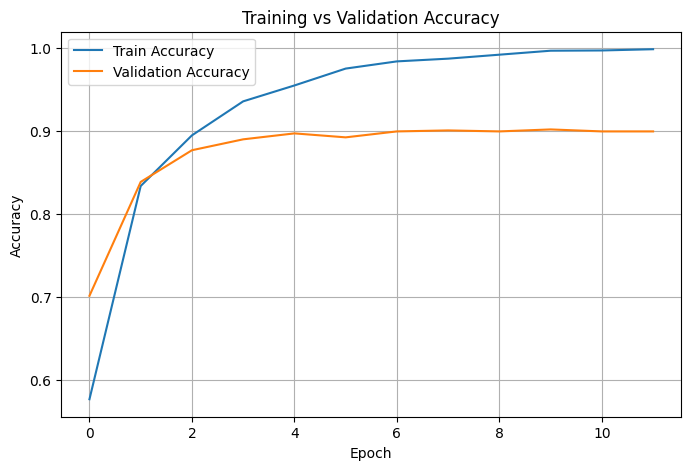

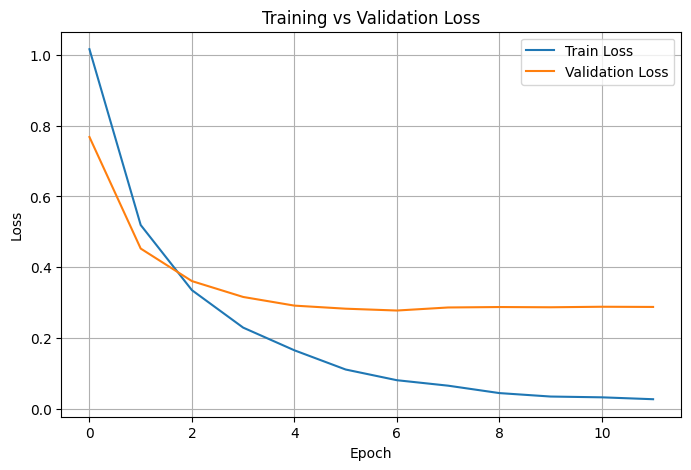

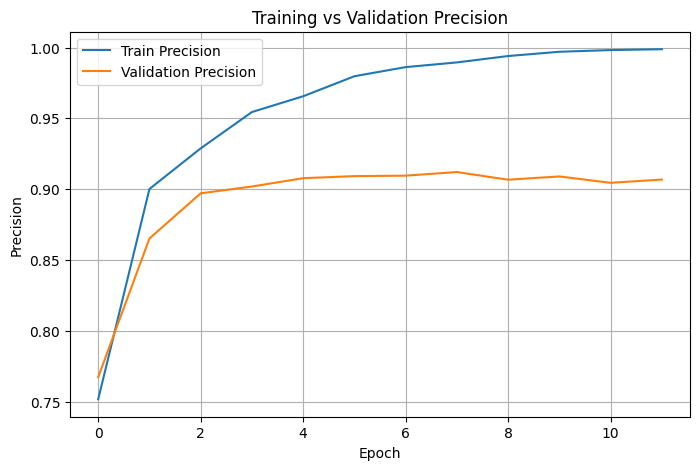

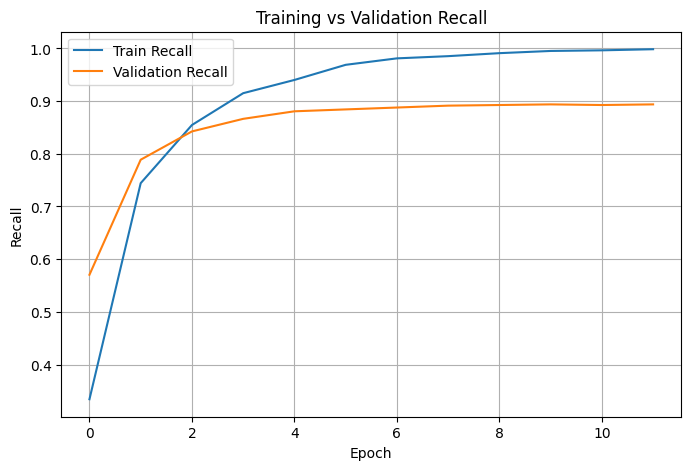

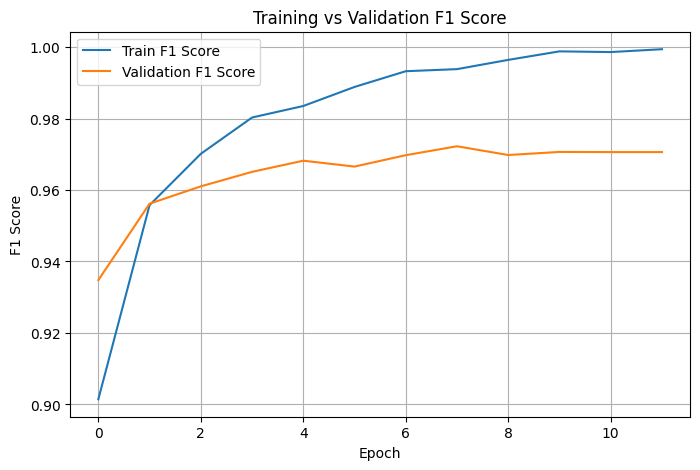

In [45]:
import matplotlib.pyplot as plt

# Get history dictionary
history_dict = history.history  # Fix: get the dictionary from history object

# List of metrics to plot if present
possible_metrics = [
    ('accuracy', 'val_accuracy', 'Accuracy'),
    ('loss', 'val_loss', 'Loss'),
    ('precision', 'val_precision', 'Precision'),
    ('recall', 'val_recall', 'Recall'),
    ('f1', 'val_f1', 'F1 Score')
]

for train_key, val_key, title in possible_metrics:
    if train_key in history_dict and val_key in history_dict:
        
        plt.figure(figsize=(8, 5))
        plt.plot(history_dict[train_key], label=f"Train {title}")
        plt.plot(history_dict[val_key], label=f"Validation {title}")
        
        plt.title(f"Training vs Validation {title}")
        plt.xlabel("Epoch")
        plt.ylabel(title)
        plt.grid(True)
        plt.legend()
        plt.show()

In [46]:
model_sequential.save("./mobileNet_model.h5")
model_sequential.save('./mobileNet_model.keras')
model.save("./ResNet_model.h5")
model.save('./ResNet_model.keras')

In [8]:
def build_efficientnet_model(num_classes=4):
    # 1. Setup Input (Using 224x224 as defined in your data loader)
    # Note: EfficientNetV2L natively prefers 480x480, but 224 works for transfer learning
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # 2. Load Base Model
    # include_top=False removes the 1000-class ImageNet layer
    base_model = tf.keras.applications.EfficientNetV2L(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_preprocessing=True, # Handles normalization internally
        pooling='avg' # Applies GlobalAveragePooling immediately
    )

    # 3. Freeze the base model
    # We freeze weights so we don't destroy learned features during initial training
    base_model.trainable = False

    # 4. Connect Input to Base
    # training=False ensures BatchNormalization layers run in inference mode
    x = base_model(inputs, training=False)

    # 5. Add Custom Head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x) # Regularization to prevent overfitting
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # 6. Create Model
    model = tf.keras.Model(inputs, outputs, name="EfficientNetV2L_Custom")
    
    return model

# Instantiate the model
effnet_model = build_efficientnet_model(num_classes=4)
effnet_model.summary()

Model: "EfficientNetV2L_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 1280)           │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,404,772 (451.68 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [ ]:
# Define Metrics
metrics = [
    'accuracy',
    tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
    F1Score(name='f1')
]

# Compile
effnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=metrics
)

# Setup Callbacks (Optional but recommended for large mox`dels)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

# Train
history_effnet = effnet_model.fit(
    train_set,
    validation_data=validation_set,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
 13/105 ━━━━━━━━━━━━━━━━━━━━ 10:43 7s/step - accuracy: 0.9217 - cat_accuracy: 0.9217 - f1: 0.9766 - loss: 0.2044

KeyboardInterrupt: 